# Wavenet for time series prediction

In this tutorial, we show how to quickly set up and train an CNN regression model with the deep4cast package. The dataset we're using is from the GEFCom2014 forecasting competition and involved hourly energy load forecasting.

In [1]:
import numpy as np

import matplotlib.pyplot as plt

from deep4cast.forecasters import Forecaster
import deep4cast.topologies as topologies

import deep4cast.custom_metrics as metrics
from pandas import read_table

%matplotlib inline

# Fix random number seed for reproducibility
np.random.seed(3) 

Using TensorFlow backend.


## Data preparation

In [2]:
# Load the data from file
filename = '../data/energy.csv'
df = read_table(filename, sep=',')

# Prepare the data set
data = df[['load', 'temp']].astype('float32').values
data = np.expand_dims(data, axis=0)

# We just need a small holdout dataset for evaluation purposes
holdout = 24 # hours
train_data = data[:,:-holdout,[0]]
test_data = data[:,-holdout:,[0]]

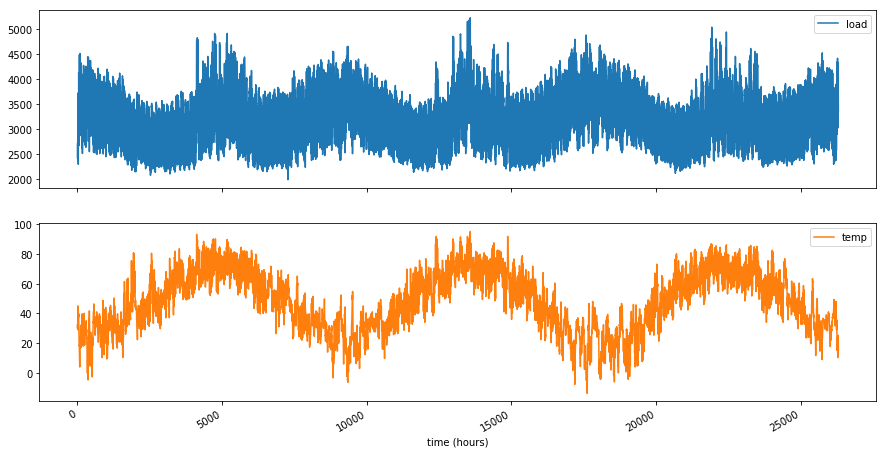

In [3]:
# Let plot the data
df.plot(subplots=True, figsize=(15, 8))
plt.xlabel('time (hours)')
plt.show()

# Modeling

In [4]:
topology = topologies.WaveNet(num_filters=32, num_layers=4)

In [20]:
forecaster = Forecaster(
    topology,
    lag=48,  # This is the number of time steps used to predict the future for each data point
    horizon=24,  # This is how many time steps into the future we want to produce
    lr=0.001,  # This is the learning rate for the optimizer
    epochs=20
)

In [21]:
forecaster.fit(train_data, targets=[0], verbose=1)

Train on 23581 samples, validate on 2557 samples
Epoch 1/20
23581/23581 [==============================] - 11s 479us/step - loss: -0.2958 - val_loss: -1.2404
Epoch 2/20
23581/23581 [==============================] - 8s 353us/step - loss: -1.2299 - val_loss: -1.5333
Epoch 3/20
23581/23581 [==============================] - 9s 388us/step - loss: -1.5046 - val_loss: -1.7370
Epoch 4/20
23581/23581 [==============================] - 8s 338us/step - loss: -1.6534 - val_loss: -1.7788
Epoch 5/20
23581/23581 [==============================] - 8s 341us/step - loss: -1.7572 - val_loss: -1.9034
Epoch 6/20
23581/23581 [==============================] - 8s 344us/step - loss: -1.8339 - val_loss: -1.9462
Epoch 7/20
23581/23581 [==============================] - 8s 345us/step - loss: -1.8905 - val_loss: -1.9855
Epoch 8/20
23581/23581 [==============================] - 8s 349us/step - loss: -1.9370 - val_loss: -2.0286
Epoch 9/20
23581/23581 [==============================] - 8s 356us/step - loss: -1.986

Text(0,0.5,"['Loss', 'Validation Loss']")

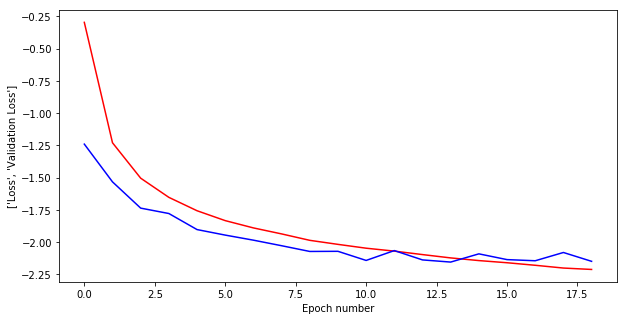

In [22]:
plt.figure(figsize=(10,5))
plt.plot(forecaster.history.epoch, forecaster.history.history['loss'], 'r')
plt.plot(forecaster.history.epoch, forecaster.history.history['val_loss'], 'b')
plt.xlabel('Epoch number')
plt.ylabel(['Loss', 'Validation Loss'])

# Evaluation

In [23]:
predictions = forecaster.predict(data=train_data, n_samples=1000)

In [24]:
print('MSE: {}'.format(round(metrics.mse(predictions['mean'], test_data[:,:,:1]), 2)))
print('MAPE: {}%'.format(round(metrics.mape(predictions['mean'], test_data[:,:,:1]), 2)))
print('SMAPE: {}%'.format(round(metrics.smape(predictions['mean'], test_data[:,:,:1]), 2)))

MSE: 13010.04
MAPE: 2.47%
SMAPE: 2.46%


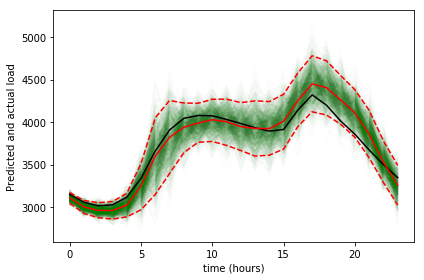

In [26]:
# We're printing the test set data and the predictions for the load data
plt.plot(predictions['samples'][:,0,:,0].T, 'g', alpha=0.01)
plt.plot(test_data[0,:,0].T, 'k')
plt.plot(predictions['mean'][0,:,0], 'r')
plt.plot(predictions['lower_quantile'][0,:,0], 'r--')
plt.plot(predictions['upper_quantile'][0,:,0], 'r--')
plt.xlabel('time (hours)')
plt.ylabel('Predicted and actual load')
plt.tight_layout()